In [266]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import hashlib
import matplotlib.pyplot as plt
import scipy.spatial
import pickle, os, time
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth=True

iblayername = 'noisy_ib_layer/RawInput:0'
# iblayername = 'encoder_2' #!!!!

n_average_epoch = 30  # Average results for these last n epochs, to smooth



import entropy, loaddata, mc_entropy
import loaddata

#basedir, desc = 'saveddata3/Regression/v1', 'Regression'
#basedir, desc = 'saveddata4/Regression/v2', 'Regression'
#basedir, desc = 'saveddata/MNIST/v1', 'MNIST'
#basedir, desc = 'saveddata3/NoisyClassifier/v1', 'NoisyClassifier'
#basedir, desc = 'saveddata3/NoisyClassifierWine/v2', 'NoisyClassifierWine'
#basedir, desc = 'saveddata3/NoisyClassifierWine/v3d', 'NoisyClassifierWineV3'
#basedir, desc = 'saveddata3/NoisyClassifierWine/v13', 'NoisyClassifierWineV10'
# basedir, desc = 'saveddata4/NoisyClassifierWine/v1', 'NoisyClassifierWineV10'

#basedir, desc = 'saveddata-scipy/NoisyClassifier/v1', 'NoisyClassifier'
#basedir, desc = 'saveddata-scipy/MNIST/v1', 'MNIST'
#basedir, desc = 'saveddata-v200/MNIST', 'MNIST'


#basedir = 'saveddata-final2/MNIST', 'MNIST' # reg vs sq
basedir = 'saveddata-final4/MNIST/v6'

#basedir = 'saveddata-final2/Delicious/v5', 'Delicious'
#basedir = 'saveddata-final3/Delicious/v1-nhidden2'

#basedir =  'saveddata-final4/Autompg/v14/'

basedir =  'saveddata-final4/Wine/v11'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
vals = {}
for mode in ['ce','VIB','nlIB']:
    vals[mode]         = {}
    vals[mode]['reg']  = {'tst': {}, 'trn': {}}
    vals[mode]['sq']   = {'tst': {}, 'trn': {}}

runtype = None
data    = None

for fname in os.listdir(basedir):
    if not (fname.startswith('results-') or fname.startswith('basemodel')):
        continue
        
    #if not fname.endswith('run0'):
    #    continue
        
    print(basedir + '/' + fname)
    with open(basedir + '/' + fname + '/data', 'rb') as f:
        try:
            cfg, saved_data = pickle.load(f)
        except:
            print("Error loading pickle file")
            continue
            
        
    #if runtype is None:
    runtype = cfg['runtype']
    data    = loaddata.load_data(runtype)

    #elif 'runtype' in cfg and runtype != cfg['runtype']:
    #    raise Exception('Mixed runtypes!')

    sqmode = 'sq' if cfg['squaredIB'] else 'reg'
    beta   = saved_data[0]['beta']
    mode   = saved_data[0]['mode']
    #if False and 'loss' in saved_data[0]['trn']:
    #    losses = np.array([r['trn']['loss'] for r in saved_data])
    #    lrow = saved_data[len(losses)-best_of_last+np.argmin(losses[-best_of_last:])]
    #else:
    #    lrow = saved_data[-1]
    #_, mode, *_ = fname.split("-",)
    for r in ['trn','tst']:
        val_dict = {}
        permutation  = np.random.permutation(len(data[r+'_Y']))
        Xbatch = data[r+'_X'][permutation][:2000]
        tf.reset_default_graph()
        with tf.Session() as sess:
            try:
                #if True:
                saver = None
                for lrow in saved_data[-n_average_epoch:]:
                    var   = lrow['noisevar']
                    l     = lrow[r]
                    epoch = lrow['epoch']

                    epoch_fname = '%s/%s/tf_model-%d' % (basedir, fname, epoch)
                    
                    h = hashlib.md5(open(epoch_fname+'.data-00000-of-00001','rb').read()).hexdigest() + '-' + r
                    cache_dir = '.mc_entropy_cache'
                    if not os.path.exists(cache_dir):
                        os.makedirs(cache_dir)
                        
                    if not os.path.exists(cache_dir + '/'+h):
                        if saver is None:
                            saver = tf.train.import_meta_graph(tf.train.latest_checkpoint('%s/%s' % (basedir, fname))+'.meta')
                            
                        saver.restore(sess, epoch_fname)
                        ##print( sess.run('decoder_0', feed_dict={'X:0':Xbatch}) )
                        #print([n.name for n in tf.get_default_graph().as_graph_def().node])
                        mx = sess.run(iblayername, feed_dict={'X:0':Xbatch})
                        n, d  = mx.shape
                        mcH   = mc_entropy.get_mc_entropy(mx, var)
                        hCond = entropy.gaussian_entropy_np(d, var)
                        l['Ixt_mc'] = mcH - hCond
                        with open(cache_dir + '/'+h, 'wb') as f:
                            pickle.dump(l, f)
                    else:
                        with open(cache_dir + '/'+h, 'rb') as f:
                            l = pickle.load(f)
                        
                    for k in ['Ixt','Ixt_lb','Iyt','Ixt_mc','ce']:
                        if k not in val_dict:
                            val_dict[k]=0.
                        val_dict[k] += l[k]/n_average_epoch
            except:
                print("Error loading tensorflow model")
                continue

        print('%s %s beta: %4g ce: %0.3f Ixt: %0.3f-%0.3f (%0.3f) Iyt: %0.3f' % 
              (r, sqmode, beta, val_dict['ce'], val_dict['Ixt_lb'], val_dict['Ixt'], val_dict['Ixt_mc'], val_dict['Iyt']))

        if beta not in vals[mode][sqmode][r] or \
           (val_dict['Ixt_mc'] <= vals[mode][sqmode][r][beta]['Ixt_mc'] and 
            val_dict['Iyt']    >= vals[mode][sqmode][r][beta]['Iyt']):
            vals[mode][sqmode][r][beta] = val_dict
            if False:
                plt.figure()
                plt.scatter(mx[:,0], mx[:,1], s=l['noisevar'], alpha=.3)
                plt.title('beta=%g mode=%s'%(beta, mode))
    print()

saveddata-final4/Wine/v11/basemodel
trn sq beta:    0 ce: 0.528 Ixt: 7.514-7.514 (-730605.985) Iyt: 0.150
tst sq beta:    0 ce: 0.569 Ixt: 7.507-7.507 (-1286488.447) Iyt: 0.109

saveddata-final4/Wine/v11/results-nlIB-0.00032-sq-run0
trn sq beta: 0.000316228 ce: 0.495 Ixt: 4.670-5.852 (4.999) Iyt: 0.183
tst sq beta: 0.000316228 ce: 0.568 Ixt: 4.676-5.859 (5.012) Iyt: 0.110

saveddata-final4/Wine/v11/results-VIB-0.00032-sq-run0
trn sq beta: 0.000316228 ce: 0.496 Ixt: 2.006-3.230 (2.385) Iyt: 0.182
tst sq beta: 0.000316228 ce: 0.575 Ixt: 2.004-3.227 (2.387) Iyt: 0.103

saveddata-final4/Wine/v11/results-nlIB-0.00079-sq-run0
trn sq beta: 0.000794328 ce: 0.509 Ixt: 1.948-2.846 (2.215) Iyt: 0.169
tst sq beta: 0.000794328 ce: 0.567 Ixt: 1.932-2.832 (2.194) Iyt: 0.111

saveddata-final4/Wine/v11/results-VIB-0.00079-sq-run0
trn sq beta: 0.000794328 ce: 0.508 Ixt: 1.467-2.567 (1.826) Iyt: 0.170
tst sq beta: 0.000794328 ce: 0.583 Ixt: 1.463-2.567 (1.824) Iyt: 0.095

saveddata-final4/Wine/v11/result

No handles with labels found to put in legend.
/home/artemy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
No handles with labels found to put in legend.
/home/artemy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


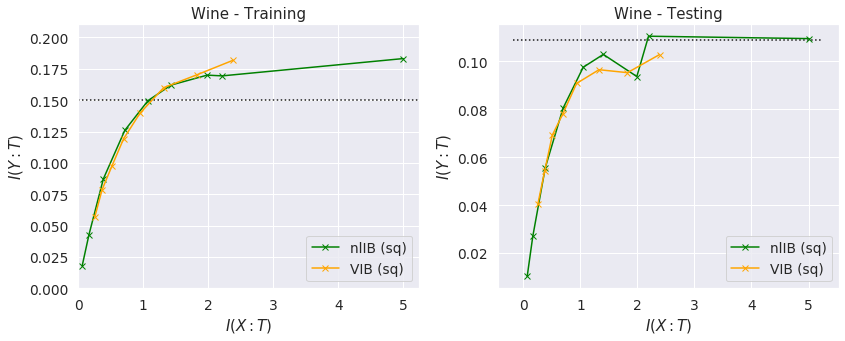

In [268]:
import seaborn as sns
sns.set_style('white')
sns.set(font_scale=1.25)
colordict={('nlIB','reg'):'blue', ('nlIB','sq'):'green', ('VIB','reg'):'red', ('VIB','sq'):'orange'}

plt.figure(figsize=(12,5))
for rndx, r in enumerate(['trn','tst']):
    for sqmode in ['reg','sq']:
        if rndx == 0:
            ax1 = plt.subplot(1,2,rndx+1)
        else:
            plt.subplot(1,2,rndx+1) #, sharex = ax1, sharey= ax1)
        for mode in ['nlIB', 'VIB']:
            d     = vals[mode][sqmode][r]
            bvals = sorted(d.keys())
            xt    = [d[b]['Ixt'] for b in bvals]
            xtlb  = [d[b]['Ixt_lb'] for b in bvals]
            xtmc  = [d[b]['Ixt_mc'] for b in bvals]
            yt    = [d[b]['Iyt'] for b in bvals]
            if len(xtmc):
                plt.plot(xtmc, yt, ls={'reg':'-','sq':'-'}[sqmode], 
                         color=colordict[(mode,sqmode)],
                         marker='x', markersize=6, markerfacecolor='none', markeredgewidth=1,
                         label=mode + " (%s)" % sqmode)
                #plt.fill_betweenx(yt, xtlb, xt, alpha=0.3, label=mode + " (%s) bounds" % sqmode)
        plt.ylabel('$I(Y:T)$')
        plt.xlabel('$I(X:T)$')
        plt.legend(loc='lower right')
        plt.title(runtype + ' - ' + {'tst':'Testing', 'trn':'Training'}[r])

        #plt.ylim([0, plt.ylim()[1]])
        #plt.xlim([0, plt.xlim()[1]])
        if False and runtype == 'MNIST':
            maxv = 1.1*plt.ylim()[1]
            plt.plot([0, maxv], [0,maxv], 'k--', lw=1)
            plt.xlim([0, maxv])
            
        # Plot optimal Gaussian IB curve 
        #   doesn't seem to work ! -- suspect it has to do with dimensionality
        if False and runtype=='Regression':
            with open('data/regression-10-100.pkl', 'rb') as f:
                data = pickle.load(f)
            mx = np.hstack([data[r+'_data'], data[r+'_labels']])
            xdims = data[r+'_data'].shape[1]
            xs, ys = entropy.get_gib_curve(np.cov(mx.T.astype('float64')), xdims)
            #print(xs, ys)
            plt.plot(xs/10, ys, c='k',label='Optimal')
            
        if len(vals['ce'][sqmode][r]):
            baselineIyt = vals['ce'][sqmode][r][0.0]['Iyt']
    
    if rndx == 0 and plt.ylim()[0]>0:
        plt.ylim([0, plt.ylim()[1]*1.1])
        plt.xlim([0, plt.xlim()[1]])
        #plt.xlim([0,8])
        #plt.ylim([0, .3])
    if runtype == 'MNIST':
        plt.plot([0, 5], [0, 5], '--k')
        plt.ylim([0, 2.5])
        plt.xlim([0, 4])
        
    plt.hlines(baselineIyt,  plt.xlim()[0], plt.xlim()[1], linestyles=':')
    
    #rng = [0.7*max(yt), 1.3*max(yt)]
    #plt.xlim(rng)
    #plt.ylim(rng)

plt.tight_layout()
# plt.savefig('plots/%s.pdf'%desc)
    
    